# TODO
- fix so that model uses q_true and s_true

In [2]:
%load_ext autoreload
%autoreload 2

#https://mc-stan.org/docs/2_18/stan-users-guide/bayesian-measurement-error-model.html

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# add noise to prediction

In [4]:
#from mdm.dataset import Standardization, LogTransform
RANDOM_SEED=1985

In [5]:
import pandas as pd
import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano.tensor as tt

In [6]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df = pd.read_csv("../data/co_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

In [7]:
def tt_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
        
    x_std = (x - tt.mean(x_o)) / tt.std(x_o)
    return x_std


def tt_unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * tt.std(x_o) + tt.mean(x_o)
    return x

def unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * np.std(x_o) + np.mean(x_o)
    return x


def tt_log_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x)
    log_x_o = tt.log(x_o)
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std
    

def tt_log_unstandardize(x_std, x_o):

    log_x_o = tt.log(x_o) #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x)
    
def tt_standardize_stage(x, offset, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x) - offset
    log_x_o = tt.log(x_o) - offset
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std

def tt_unstandardize_stage(x_std, offset, x_o):

    log_x_o = tt.log(x_o) - offset #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x + offset)

# plotting?
def predictive_plot(ppc, q_obs, s_obs, offset=False, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    s_obs.min()
    s_min = np.floor(s_obs.min())
    s_max = np.ceil(s_obs.max())
    s_sim = np.linspace(s_min, s_max)
    
    if offset:
        o = ppc['offset']
    else:
        o = 0
      
    #predictor_scaled = tt_log_standardize(s_sim-o, s_obs-o).eval()
    #q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()
    
    #log_mu_ppq = (ppc["a"] + ppc["b"] * np.log(s_obs - o)).T
    log_mu_ppq = ppc['a'].reshape(-1,1) + ppc['b'].reshape(-1,1)*np.log((s_sim.reshape(1,-1) - ppc['offset'].reshape(-1,1)))
    log_pred_ppq = log_mu_ppq + ppc['sigma'].reshape(-1,1) * pm.Normal.dist(0,1).random(size=(4000,50))
    
    mu_ppq = np.exp(log_mu_ppq)
    pred_ppq = np.exp(log_pred_ppq)
    
    
    
    #plt.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data", color='k')
    
    ax.errorbar(df['stage'],  df['q'], yerr=1.96*df['q_sigma'], fmt='.k');
    
    ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)
    
    
    az.plot_hdi(
        s_sim,
        pred_ppq,
        ax=ax,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Predictive 94% HPD"},
    )
    
    
    ax.set_xlabel("Stage (feet)")
    ax.set_ylabel("Discharge (ft3/s)")
    
    ax.legend(ncol=2, fontsize=10)

In [8]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [9]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_true - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q = pm.Lognormal("q",
                 mu=mu,
                 sigma=sigma,
                 observed=q_true)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [12]:
with error_model:
    error_trace = pm.sample(1000, tune=1000, return_inferencedata=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<ipython-input-13-307171b1fec8>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(error_trace)
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'offset'}>,
        <AxesSubplot:title={'center':'offset'}>]], dtype=object)

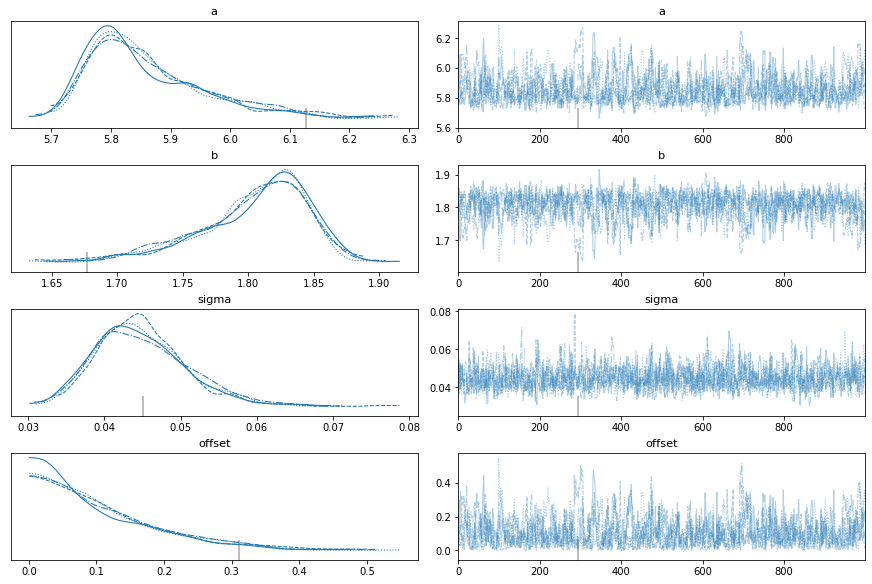

In [13]:
pm.traceplot(error_trace)

In [ ]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q_log = pm.Normal("q_log",
                 mu=mu,
                 sigma=sigma,
                 observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [18]:
with error_model:
    error_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 102 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


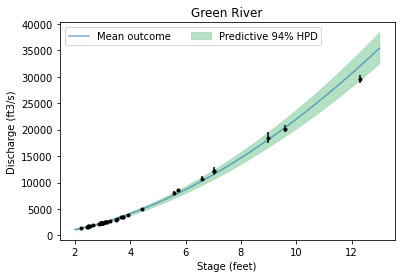

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Green River")
fig.savefig("../figures/green_channel.pdf")

In [20]:
output=pd.DataFrame()

In [21]:
site = 'Green River'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

#log_q = np.log(q_obs)
#log_s = np.log(s_obs-offset)
#a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
#b_s = b*log_q.std()/log_s.std()
#sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma)**1.96

results = pd.Series({'a':a,'b':b, 'offset':offset, 'sigma':sigma, 'gerr95':gerr95}, name=site)
output = output.append(results)

In [22]:
output

,a,b,gerr95,offset,sigma
Green River,5.904799,1.788791,1.076985,0.141161,0.03784


In [23]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/co_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [24]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q_log = pm.Normal("q_log",
                 mu=mu,
                 sigma=sigma,
                 observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [25]:
with error_model:
    error_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 150 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


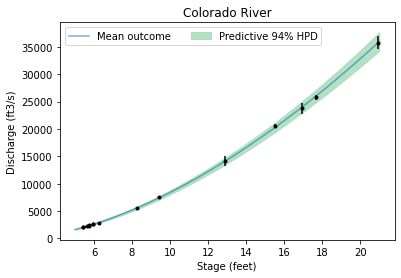

In [26]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Colorado River")
fig.savefig("../figures/co_channel.pdf")

In [27]:
site = 'Colorado River'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

#log_q = np.log(q_obs)
#log_s = np.log(s_obs-offset)
#a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
#b_s = b*log_q.std()/log_s.std()
#sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma)**1.96

results = pd.Series({'a':a,'b':b, 'offset':offset, 'sigma':sigma, 'gerr95':gerr95}, name=site)
output = output.append(results)

In [28]:

#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/chalk_artificial.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [29]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q_log = pm.Normal("q_log",
                 mu=mu,
                 sigma=sigma,
                 observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [30]:
with error_model:
    error_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 111 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<ipython-input-15-719d56f2976c>:70: RuntimeWarning: invalid value encountered in log
  log_mu_ppq = ppc['a'].reshape(-1,1) + ppc['b'].reshape(-1,1)*np.log((s_sim.reshape(1,-1) - ppc['offset'].reshape(-1,1)))
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


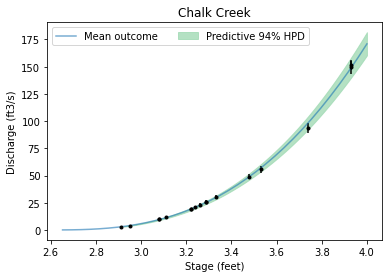

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Chalk Creek")
fig.savefig("../figures/chalk_artificial.pdf")

In [32]:
site = 'Chalk Creek'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

#log_q = np.log(q_obs)
#log_s = np.log(s_obs-offset)
#a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
#b_s = b*log_q.std()/log_s.std()
#sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma)**1.96

results = pd.Series({'a':a,'b':b, 'offset':offset, 'sigma':sigma, 'gerr95':gerr95}, name=site)
output = output.append(results)

In [33]:

#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/provo_natural.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
q_sigma = q_sigma
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [34]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, offset_max)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - offset)
    #y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_obs)
    q_log = pm.Normal("q_log",
                 mu=mu,
                 sigma=sigma,
                 observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [35]:
with error_model:
    error_trace = pm.sample(1000, tune=2000, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 105 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


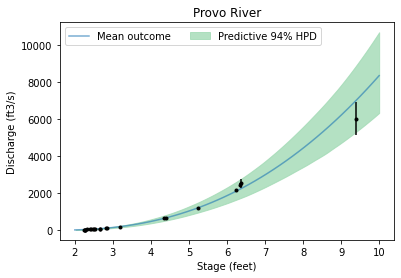

In [36]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, offset=True, ax=ax)
ax.set_title("Provo River")
fig.savefig("../figures/provo_natural.pdf")

In [37]:
site = 'Provo River'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

#log_q = np.log(q_obs)
#log_s = np.log(s_obs-offset)
#a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
#b_s = b*log_q.std()/log_s.std()
#sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma)**1.96

results = pd.Series({'a':a,'b':b, 'offset':offset, 'sigma':sigma, 'gerr95':gerr95}, name=site)
output = output.append(results)

In [39]:
output.to_csv('../simple_offset_unstd_rating.csv')

In [ ]:
output

In [60]:
s_sim

array([ 2.        ,  2.2244898 ,  2.44897959,  2.67346939,  2.89795918,
        3.12244898,  3.34693878,  3.57142857,  3.79591837,  4.02040816,
        4.24489796,  4.46938776,  4.69387755,  4.91836735,  5.14285714,
        5.36734694,  5.59183673,  5.81632653,  6.04081633,  6.26530612,
        6.48979592,  6.71428571,  6.93877551,  7.16326531,  7.3877551 ,
        7.6122449 ,  7.83673469,  8.06122449,  8.28571429,  8.51020408,
        8.73469388,  8.95918367,  9.18367347,  9.40816327,  9.63265306,
        9.85714286, 10.08163265, 10.30612245, 10.53061224, 10.75510204,
       10.97959184, 11.20408163, 11.42857143, 11.65306122, 11.87755102,
       12.10204082, 12.32653061, 12.55102041, 12.7755102 , 13.        ])

# Scratch